# PACS: train a classifier on top of pretrained features


In [785]:
import blackhc.project.script

In [786]:
from timm.data.transforms_factory import transforms_imagenet_eval
from torchvision import transforms

In [787]:
from timm.data import create_dataset, create_loader, resolve_data_config
from timm.data.transforms_factory import create_transform

In [788]:
import torch
import torch.nn

In [789]:
#torch.manual_seed(123)

In [790]:
from tqdm.auto import tqdm

In [791]:
torch.backends.cudnn.benchmark = True

In [792]:
from torch.utils.data import TensorDataset, DataLoader

In [793]:
!ls compute_results/pacs*.pt

compute_results/pacs_art_painting_features_labels_beit_large_patch16_224.pt
compute_results/pacs_art_painting_features_labels_convnext_large_in22ft1k.pt
compute_results/pacs_art_painting_features_labels_deit3_large_patch16_224_in21ft1k.pt
compute_results/pacs_art_painting_features_labels_resnet152d.pt
compute_results/pacs_art_painting_features_labels_vit_base_patch16_384.pt
compute_results/pacs_cartoon_features_labels_beit_large_patch16_224.pt
compute_results/pacs_cartoon_features_labels_convnext_large_in22ft1k.pt
compute_results/pacs_cartoon_features_labels_deit3_large_patch16_224_in21ft1k.pt
compute_results/pacs_cartoon_features_labels_resnet152d.pt
compute_results/pacs_cartoon_features_labels_vit_base_patch16_384.pt
compute_results/pacs_cartoon_sketch_beit_large_patch16_224_ensemble_probs_labels.pt
compute_results/pacs_cartoon_sketch_convnext_large_in22ft1k_ensemble_probs_labels.pt
compute_results/pacs_cartoon_sketch_deit3_large_patch16_224_in21ft1k_ensemble_probs_labels.pt
compute_

In [794]:
#architecture="resnet152d"
#architecture="beit_large_patch16_224"
#architecture="convnext_large_in22ft1k"
#architecture="vit_base_patch16_384"
#architecture="deit3_large_patch16_224_in21ft1k"

In [795]:
def get_feature_path(name):
    return f"compute_results/pacs_{name}_features_labels_{architecture}.pt"

In [796]:
features_info = torch.load(get_feature_path("photo"))

In [797]:
other_features_info = torch.load(get_feature_path("art_painting"))

In [798]:
features = features_info["features"]

In [799]:
labels = features_info["labels"]

In [800]:
print(features_info["pretrained_cfg"])
print(features_info["subdataset"])

{'url': 'https://dl.fbaipublicfiles.com/deit/deit_3_large_224_21k.pth', 'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None, 'crop_pct': 1.0, 'interpolation': 'bicubic', 'fixed_input_size': True, 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'first_conv': 'patch_embed.proj', 'classifier': 'head', 'architecture': 'deit3_large_patch16_224_in21ft1k'}
photo


In [801]:
feature_label_dataset = TensorDataset(features.cuda(), labels.cuda())

In [802]:
labels.max()

tensor(6)

In [803]:
feature_label_loader = DataLoader(feature_label_dataset, shuffle=True, batch_size=128, drop_last=True)

In [804]:
def get_test_accuracy(model, other_features_info):
    with torch.inference_mode():
        accuracy = torch.sum(model(other_features_info["features"].cuda()).argmax(dim=-1) == other_features_info["labels"].cuda())
        rel_accuracy = accuracy.item()/len(other_features_info['labels'])
    return f"{rel_accuracy} ({accuracy.item()}/{len(other_features_info['labels'])})"

In [805]:
def get_test_loss(model, other_features_info):
    with torch.inference_mode():
        loss = torch.nn.functional.cross_entropy(model(other_features_info["features"].cuda()), other_features_info["labels"].cuda())
    return loss.item()

In [806]:
import torch.optim

In [807]:
def train(feature_label_loader, other_feature_info):
    model = torch.nn.Linear(feature_label_loader.dataset.tensors[0].shape[1], 7, device="cuda")
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
    
    for epoch in tqdm(range(1000)):
        losses = 0
        for batch_features, batch_labels in feature_label_loader:
            optimizer.zero_grad()
            logits = model(batch_features)        
            loss = torch.nn.functional.cross_entropy(logits, batch_labels)
            loss.backward()
            optimizer.step()
            losses += loss.item()
        
    print("Loss:", losses/len(feature_label_loader))    
    test_accuracy = get_test_accuracy(model, other_features_info)
    print("Validation Accuracy:", test_accuracy)
    print("Validation Loss:", get_test_loss(model, other_features_info))
    return model

In [808]:
ensemble_models = [train(feature_label_loader, other_features_info) for _ in range(5)]

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 5.150928244618696e-08
Validation Accuracy: 0.83447265625 (1709/2048)
Validation Loss: 0.6504312753677368


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 5.057796014485715e-08
Validation Accuracy: 0.82177734375 (1683/2048)
Validation Loss: 0.7403531074523926


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 4.8213836615437124e-08
Validation Accuracy: 0.818359375 (1676/2048)
Validation Loss: 0.7954893112182617


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 5.3371925955703915e-08
Validation Accuracy: 0.8408203125 (1722/2048)
Validation Loss: 0.6489322781562805


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 4.9360078281123464e-08
Validation Accuracy: 0.82080078125 (1681/2048)
Validation Loss: 0.738153874874115


In [809]:
# Get cartoons and sketches together
cartoon_feature_info = torch.load(get_feature_path("cartoon"))
sketch_feature_info = torch.load(get_feature_path("sketch"))

In [810]:
shifted_features = torch.cat([other_features_info["features"], cartoon_feature_info["features"], sketch_feature_info["features"]])
shifted_labels = torch.cat([other_features_info["labels"], cartoon_feature_info["labels"], sketch_feature_info["labels"]])

In [811]:
shifted_feature_info = dict(features=shifted_features, labels=shifted_labels)

In [812]:
[get_test_accuracy(ensemble_model, shifted_feature_info) for ensemble_model in ensemble_models]

['0.6930657372911909 (5767/8321)',
 '0.680086528061531 (5659/8321)',
 '0.6782838601129672 (5644/8321)',
 '0.694507871650042 (5779/8321)',
 '0.6612186035332291 (5502/8321)']

In [813]:
with torch.inference_mode():
    ensemble_logits = torch.stack([ensemble_model(shifted_features.cuda()) for ensemble_model in ensemble_models], dim=1)

In [814]:
ensemble_logits.shape

torch.Size([8321, 5, 7])

In [815]:
ensemble_probs = torch.nn.functional.softmax(ensemble_logits, dim=-1).cpu()

In [816]:
architecture = features_info["pretrained_cfg"]["architecture"]
architecture

'deit3_large_patch16_224_in21ft1k'

In [817]:
validation_info = dict(predictions=ensemble_probs, labels=shifted_labels, pretrained_cfg={**features_info["pretrained_cfg"], architecture:f"Linear Model on top of {architecture}"})

torch.save(validation_info, f"pacs_cartoon_sketch_{architecture}_ensemble_probs_labels.pt")

In [818]:
validation_info["pretrained_cfg"]

{'url': 'https://dl.fbaipublicfiles.com/deit/deit_3_large_224_21k.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': None,
 'crop_pct': 1.0,
 'interpolation': 'bicubic',
 'fixed_input_size': True,
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'patch_embed.proj',
 'classifier': 'head',
 'architecture': 'deit3_large_patch16_224_in21ft1k',
 'deit3_large_patch16_224_in21ft1k': 'Linear Model on top of deit3_large_patch16_224_in21ft1k'}

# Verify Info Gain

In [819]:
def entropy(probs):
  """Compute the prediction entropy for each ensemble member separately."""
  nats = probs * torch.log(probs)
  nats[nats.isnan()]=0.
  return -nats.sum(dim=-1)

In [820]:
def ensemble_entropy(probs):
  """Compute the ensemble prediction entropy."""
  mean_probs = probs.mean(dim=1, keepdim=False)
  
  nats = mean_probs * mean_probs.log()
  nats[nats.isnan()]=0.
  entropy = -nats.sum(dim=-1)

  return entropy

In [821]:
def info_gain(logits):
  p_entropy = ensemble_entropy(logits)

  avg_softmax_entropies = entropy(logits).mean(dim=1,keepdim=False)

  value = p_entropy - avg_softmax_entropies
  return value


In [822]:
info_gain(ensemble_probs).max()

tensor(0.4564)

In [823]:
import seaborn as sns

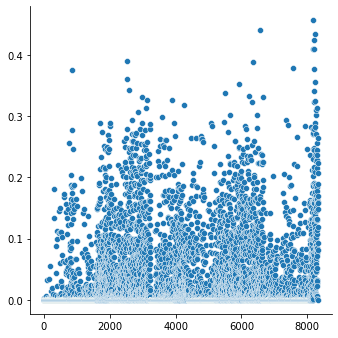

In [824]:
sns.relplot(info_gain(ensemble_probs).numpy())